### Imports & Setup

In [8]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


### Load Features & Extract Actor IDs

In [9]:
# Load data
df = pd.read_csv("features.csv")

# ===== CRITICAL FIX HERE =====
# Get only numeric feature columns (f0-f80), exclude filename!
feature_cols = [col for col in df.columns if col.startswith('f') and col != 'filename']
X = df[feature_cols].values  # Only 81 numeric features
y = df["emotion"].values

print(f"Feature matrix shape: {X.shape}")  # Should be (1440, 81)
print(f"Feature columns: {len(feature_cols)}")  # Should be 81

# Extract actor IDs for GroupKFold
def get_actor_id(name):
    if pd.isna(name):
        return 0
    return int(name.split("-")[6].split(".")[0])

groups = df["filename"].apply(get_actor_id).values

print("Total samples:", len(X))

Feature matrix shape: (1440, 81)
Feature columns: 81
Total samples: 1440


### Train-Val-Test Split (70-15-15)

In [10]:
# Train-Val-Test Split (70-15-15)
X_train, X_temp, y_train, y_temp, groups_train, groups_temp = train_test_split(
    X, y, groups,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test, groups_val, groups_test = train_test_split(
    X_temp, y_temp, groups_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


Train: 1008
Val: 216
Test: 216


### Standardization & Save Scaler   

In [11]:
# Standardization & Save Scaler
os.makedirs("artifacts", exist_ok=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "artifacts/standard_scaler.pkl")
print(f"\nScaler saved. Expects {scaler.n_features_in_} features.")


Scaler saved. Expects 81 features.


### Baseline Models (Default Parameters), SVM baseline

In [12]:
# SVM Baseline
svm_baseline = SVC(probability=True, random_state=42)
svm_baseline.fit(X_train_scaled, y_train)

y_val_pred_svm_base = svm_baseline.predict(X_val_scaled)
baseline_svm_val_acc = accuracy_score(y_val, y_val_pred_svm_base)
print("Baseline SVM Validation Accuracy:", baseline_svm_val_acc)

Baseline SVM Validation Accuracy: 0.6296296296296297


### Random Forest Baseline

In [13]:
# RF Baseline
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

y_val_pred_rf_base = rf_baseline.predict(X_val_scaled)
baseline_rf_val_acc = accuracy_score(y_val, y_val_pred_rf_base)
print("Baseline RF Validation Accuracy:", baseline_rf_val_acc)

Baseline RF Validation Accuracy: 0.5740740740740741


### Hyperparameter Tuning (GridSearchCV)

In [14]:
# Hyperparameter Tuning
group_kfold = GroupKFold(n_splits=5)

# SVM Grid Search
print("\n=== SVM Hyperparameter Tuning ===")
svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    "kernel": ["rbf", "linear"]
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=group_kfold.split(X_train_scaled, y_train, groups_train),
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_train_scaled, y_train)
best_svm = svm_grid.best_estimator_

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM CV Score:", svm_grid.best_score_)

y_val_pred_svm = best_svm.predict(X_val_scaled)
svm_val_acc = accuracy_score(y_val, y_val_pred_svm)
print("Tuned SVM Validation Accuracy:", svm_val_acc)

# RF Grid Search
print("\n=== RF Hyperparameter Tuning ===")
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=group_kfold.split(X_train_scaled, y_train, groups_train),
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Score:", rf_grid.best_score_)

y_val_pred_rf = best_rf.predict(X_val_scaled)
rf_val_acc = accuracy_score(y_val, y_val_pred_rf)
print("Tuned RF Validation Accuracy:", rf_val_acc)



=== SVM Hyperparameter Tuning ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best SVM Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM CV Score: 0.488577919918881
Tuned SVM Validation Accuracy: 0.5925925925925926

=== RF Hyperparameter Tuning ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV Score: 0.4371303785205387
Tuned RF Validation Accuracy: 0.5879629629629629


In [15]:
# Save models
joblib.dump(best_svm, "artifacts/svm_model.pkl")
joblib.dump(best_rf, "artifacts/random_forest_model.pkl")

print("\n✅ Models saved with CORRECT feature dimensions (81)!")
print(f"SVM expects: {best_svm.n_features_in_} features")
print(f"Scaler expects: {scaler.n_features_in_} features")



✅ Models saved with CORRECT feature dimensions (81)!
SVM expects: 81 features
Scaler expects: 81 features


### Confusion Matrices

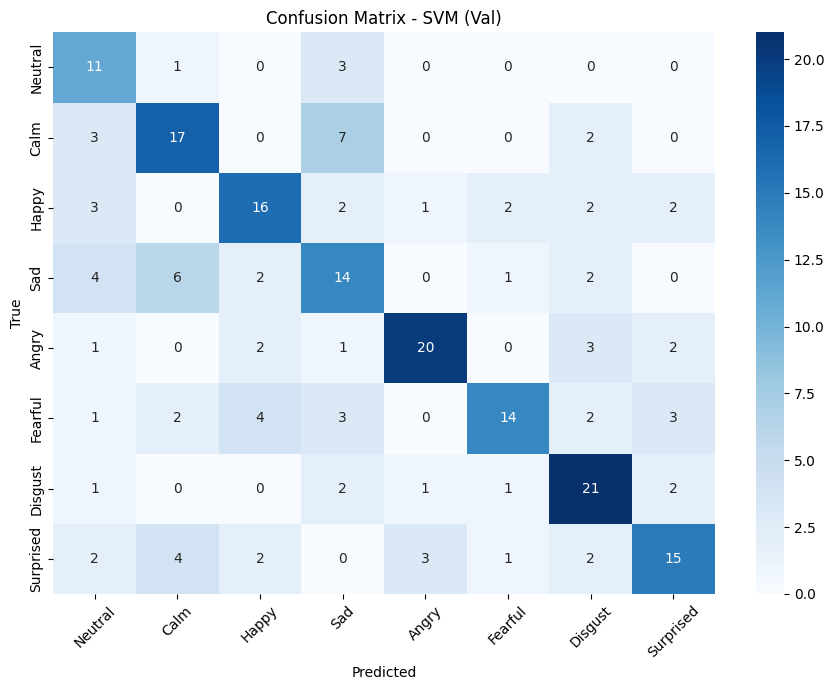

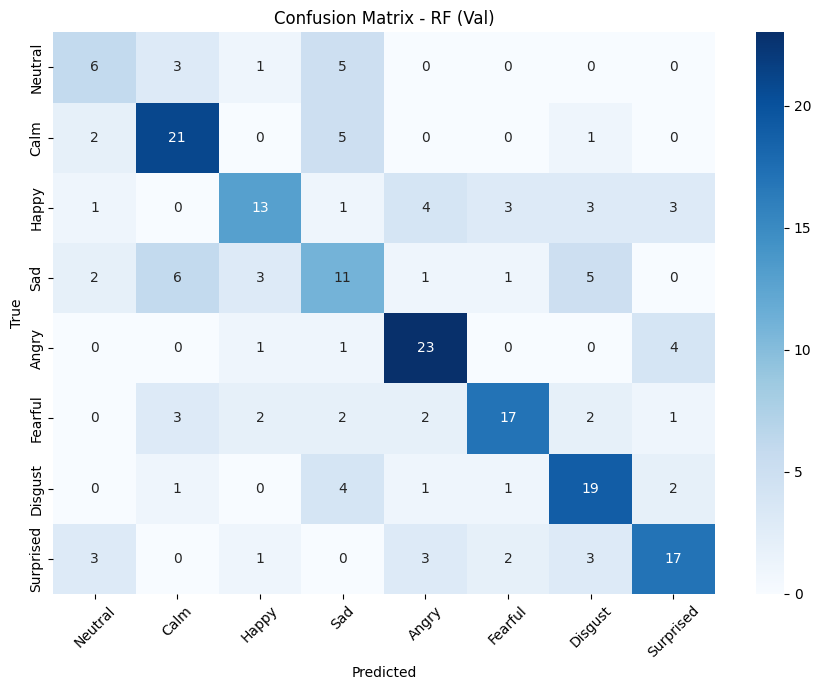


===== SVM Classification Report (Validation) =====

              precision    recall  f1-score   support

     Neutral       0.42      0.73      0.54        15
        Calm       0.57      0.59      0.58        29
       Happy       0.62      0.57      0.59        28
         Sad       0.44      0.48      0.46        29
       Angry       0.80      0.69      0.74        29
     Fearful       0.74      0.48      0.58        29
     Disgust       0.62      0.75      0.68        28
   Surprised       0.62      0.52      0.57        29

    accuracy                           0.59       216
   macro avg       0.60      0.60      0.59       216
weighted avg       0.61      0.59      0.59       216


===== Random Forest Classification Report (Validation) =====

              precision    recall  f1-score   support

     Neutral       0.43      0.40      0.41        15
        Calm       0.62      0.72      0.67        29
       Happy       0.62      0.46      0.53        28
         Sad    

In [16]:
emotion_labels = [
"Neutral","Calm","Happy","Sad",
"Angry","Fearful","Disgust","Surprised"
]

def save_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=emotion_labels,
                yticklabels=emotion_labels,
                cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

save_confusion_matrix(y_val, y_val_pred_svm,
    "Confusion Matrix - SVM (Val)",
    "artifacts/confusion_svm_val.png")

save_confusion_matrix(y_val, y_val_pred_rf,
    "Confusion Matrix - RF (Val)",
    "artifacts/confusion_rf_val.png")

svm_report = classification_report(y_val, y_val_pred_svm, target_names=emotion_labels)
rf_report = classification_report(y_val, y_val_pred_rf, target_names=emotion_labels)

print("\n===== SVM Classification Report (Validation) =====\n")
print(svm_report)

print("\n===== Random Forest Classification Report (Validation) =====\n")
print(rf_report)

with open("artifacts/svm_classification_report.txt", "w") as f:
    f.write(svm_report)

with open("artifacts/rf_classification_report.txt", "w") as f:
    f.write(rf_report)

print("Reports saved.")


### Model comparision Table

In [17]:
def metrics_summary(y_true, y_pred):
    p,r,f,_ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return acc,p,r,f

results = []

results.append(["SVM (Baseline)"] + list(metrics_summary(y_val, y_val_pred_svm_base)))
results.append(["RF (Baseline)"] + list(metrics_summary(y_val, y_val_pred_rf_base)))
results.append(["SVM (Tuned)"] + list(metrics_summary(y_val, y_val_pred_svm)))
results.append(["RF (Tuned)"] + list(metrics_summary(y_val, y_val_pred_rf)))

comparison_df = pd.DataFrame(results,
    columns=["Model","Accuracy","Precision","Recall","F1"])

comparison_df.to_csv("artifacts/model_comparison.csv", index=False)

comparison_df


,Model,Accuracy,Precision,Recall,F1
0,SVM (Baseline),0.629630,0.624888,0.619602,0.614150
1,RF (Baseline),0.574074,0.557930,0.555501,0.551495
2,SVM (Tuned),0.592593,0.602765,0.601673,0.591500
3,RF (Tuned),0.587963,0.579346,0.576478,0.574018
